# Step 1: Import and Init

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import sys
import imageio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
IMAGE_PATH = "C:\\\\Users\\sacha\\OneDrive\\Bureau\\CrashBest"

# Step 2: Retrieve Data

In [15]:
# CSV file path
CSV_PATH = "Crash_Table.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(CSV_PATH)
df

,vidname,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9,...,frame_46,frame_47,frame_48,frame_49,frame_50,startframe,youtubeID,timing,weather,egoinvolve
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,285,0,Day,Normal,Yes
1,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,646,0,Day,Normal,Yes
2,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,972,0,Day,Normal,Yes
3,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1257,0,Day,Normal,Yes
4,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,462,10,Day,Snowy,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1496,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,2116,169,Day,Snowy,Yes
1496,1497,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,2591,169,Day,Normal,Yes
1497,1498,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,4798,169,Day,Snowy,Yes
1498,1499,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,548,170,Day,Snowy,No


In [16]:
arr = []

for ind in df.index:
    for i in range(1, 51):
        arr.append(df[f"frame_{i}"][ind])

print(len(arr))

75000


# Step 3: Preparing the Data

In [6]:
dataset = keras.preprocessing.image_dataset_from_directory(BASE_PATH, labels=arr, batch_size=128, label_mode='int')

Found 75000 files belonging to 2 classes.


In [7]:
dataset = dataset.map(lambda x, y: (x / 255.0, y))

In [8]:
train_size = int(len(dataset) * 0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

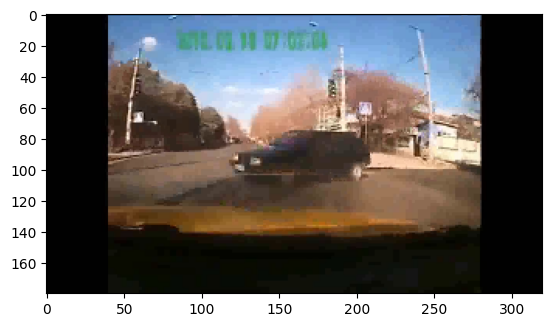

In [ ]:

FILENAME = "/C_000001_"
FRAME = "30"
SCALE = 4

img = cv2.imread(BASE_PATH + FILENAME + FRAME + ".jpg")
plt.imshow(img[::SCALE,::SCALE,::-1])


# Step 4: Build a Model

In [2]:
FILTER = 8

inputs = tf.keras.Input(shape=(256, 256, 3))

b1c1 = layers.Conv2D(FILTER, (3, 3), padding="same", activation="relu")(inputs)
b1c2 = layers.Conv2D(FILTER, (3, 3), padding="same", activation="relu")(b1c1)
rs = layers.Reshape((256, 256, FILTER))(b1c2)
mp1 = layers.MaxPooling2D((4, 4))(rs)

b2c1 = layers.Conv2D(FILTER * 2, (3, 3), padding="same", activation="relu")(mp1)
b2c2 = layers.Conv2D(FILTER * 2, (3, 3), padding="same", activation="relu")(b2c1)
mp2 = layers.MaxPooling2D((4, 4))(b2c2)

b3c1 = layers.Conv2D(FILTER * 4, (3, 3), padding="same", activation="relu")(mp2)
b3c2 = layers.Conv2D(FILTER * 4, (3, 3), padding="same", activation="relu")(b3c1)
mp3 = layers.MaxPooling2D((2, 2))(b3c2)

flat = layers.Flatten()(mp3)
fc1 = layers.Dense(128, activation="relu")(flat)
fc2 = layers.Dense(16, activation="relu")(fc1)
outputs = layers.Dense(1, activation="sigmoid")(fc2)

model = Model(inputs=inputs, outputs=outputs, name="AE")
model.compile(optimizer='adam', loss="binary_crossentropy", metrics = ['binary_accuracy'])

model.summary()

Model: "AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 256, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,537 (1.08 MB)

 Trainable params: 282,537 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
plot_model(model, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) for `plot_model` to work.


tf.Tensor(0, shape=(), dtype=int32)


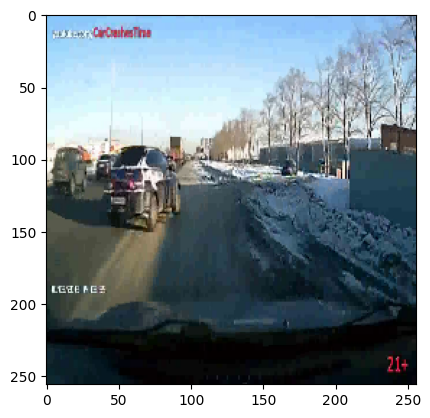

In [9]:
for t in train_ds.take(1):
    plt.imshow(t[0][0])
    print(t[1][0])

In [11]:
model.fit(train_ds, epochs=6, verbose=1, validation_data=test_ds)

Epoch 1/6
468/468 ━━━━━━━━━━━━━━━━━━━━ 267s 569ms/step - binary_accuracy: 0.7858 - loss: 0.4553 - val_binary_accuracy: 0.8045 - val_loss: 0.4136
Epoch 2/6
468/468 ━━━━━━━━━━━━━━━━━━━━ 218s 465ms/step - binary_accuracy: 0.8219 - loss: 0.3878 - val_binary_accuracy: 0.8368 - val_loss: 0.3627
Epoch 3/6
468/468 ━━━━━━━━━━━━━━━━━━━━ 207s 441ms/step - binary_accuracy: 0.8705 - loss: 0.2975 - val_binary_accuracy: 0.8794 - val_loss: 0.2897
Epoch 4/6
468/468 ━━━━━━━━━━━━━━━━━━━━ 218s 466ms/step - binary_accuracy: 0.9087 - loss: 0.2202 - val_binary_accuracy: 0.8983 - val_loss: 0.2552
Epoch 5/6
468/468 ━━━━━━━━━━━━━━━━━━━━ 184s 392ms/step - binary_accuracy: 0.9369 - loss: 0.1609 - val_binary_accuracy: 0.9103 - val_loss: 0.2508
Epoch 6/6
468/468 ━━━━━━━━━━━━━━━━━━━━ 184s 393ms/step - binary_accuracy: 0.9499 - loss: 0.1275 - val_binary_accuracy: 0.9089 - val_loss: 0.2593


In [13]:
model.save("CarCrashV1.keras")

In [ ]:
anim_file = 'test.gif'

imgs = []
filenames = [BASE_PATH + FILENAME + f"{i:02}.jpg" for i in range(1, 51)]
for filename in filenames:
    img = cv2.imread(filename)[::SCALE,::SCALE,::-1]
    imgs.append(img)

    
imgs = [Image.fromarray(img) for img in imgs]
imgs[0].save(anim_file, save_all=True, append_images=imgs[1:], duration=100, loop=0)